In [49]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import glob
import os
import math
from os import listdir
import data_visualization as dv
import pickle
import scipy 
from scipy.stats import norm
from scipy import stats
from tqdm import tqdm 
import random
import numba as nb
from numba import njit
from operator import itemgetter

wheel = dv.ColorWheel()

### Human Parameters

1. Mean Reaction Time = $\mu_{RT}$
2. Mean Movement Time = $\mu_{MT}$
3. Mean Reaction+Movement Time = $\mu_{RMT}$

4. Uncertainty of Reaction Time = $\sigma_{RT}$
5. Uncertainty of Movement Time = $\sigma_{MT}$
6. Uncertainty of Reaction+Movement Time = $\sigma_{RMT}$

In [50]:
reaction_time = 200
movement_time = 100
reaction_uncertainty = 100
movement_uncertainty = 100
reaction_movement_uncertainty = reaction_uncertainty + movement_uncertainty

### Agent Parameters

1. Agent Mean Decision Time = $\mu_{ADT}$

      $\mu_{ADT}$ = [1000,1100,1200]
     
2. Agent Uncertainty of Decision Time = $\sigma_{ADT}$

      $\sigma_{ADT}$ = [50,150]

In [51]:
agent_means = np.array([1000,1000,1100,1100,1200,1200])
agent_stds = np.array([50,150]*3)

### Human Probabilites

1. Probability of Reaching Target on Gamble = $P(Reach|G) = P(Reach Time < 1500 | t,\mu_{MT},\sigma_{MT})$
2. Probability of Reaching Target on Reaction = $P(Reach|R) = P(Reach Time < 1500 | t,\mu_{RMT},\sigma_{RMT})$

3. Probability of Selecting Correct Target on Gamble = $ P(S|G) = 0.5$
4. Probability of Selecting Correct Target on Reaction = $P(S|R) = 1.0$

### Agent Probabilities

1. Probability Agent Has Gone = $P(AG) = P(A|t,\mu_{ADT},\sigma_{ADT})$

2. Probability Agent Has Not Gone = $P(ANG) = 1 - P(A|t,\mu_{ADT},\sigma_{ADT})$

### Probability of Reward

1. Probability of Reward on Gamble = $P(W|G) = P(S|G)*P(Reach|G)*P(ANG)$
    - Probability of success AND Probability that you make it AND probability that agent hasn't gone (AKA probability that you actually gamble!!)
2. Probability of Reward on Reaction = $P(W|R) = P(S|R)*P(Reach|R)*P(AG)$
3. Total Probability of Reward =$ P(Reward) = P(W|G) + P(W|R) - (P(W|G)*P(W|R))$

### Probability of Incorrect

1. Probability of Incorrect on Gamble = $P(L|G) = (1 - P(S|G))*P(Reach|G)$
2. Probability of Incorrect on Reaction = $0$

3. Total Probability of Incorrect = $P(Incorrect) = P(L|G)$

### Probability of Indecision

1. Probability of Indecision on Gamble = $P(I|G) =  1 - P(Reach|G)$

2. Probability of Indecision on Reaction = $P(I|R) = 1 - P(Reach|R)$
3. Total Probability of Indecision = $P(Indecision) = P(I|G) + P(I|R) - (P(I|G)*P(I|R))$

### Rewards and Costs

1. Correct Decision = $R_{C} = 1$
2. Incorrect Decision = $R_{NC} = 0$

3. Indecision = $R_{I} = 0$

### Expected Rewards

1. Expected Reward of Gamble = $ER_{G} = P(X|G)*R_{C} + P(Y|G)*R_{NC} + P(I|G)*R_{I}$

2. Expected Reward of Reaction = $ER_{R} = P(X|R)*R_{C} + P(Y|R)*R_{NC} + P(I|R)*R_{I}$
3. Total Expected Reward = $ER = P(Reward)*R_{C} + P(Incorrect)*R_{NC} + P(Indecision)*R_{I}$

### Optimal Calculation Function

In [52]:
def find_optimal_decision_time(agent_mean, agent_std, reaction_time,movement_time, reaction_movement_uncertainty, movement_uncertainty,plot=False):
    timesteps = np.arange(0,2000,1)
    prob_agent_go = np.zeros(len(timesteps))
    prob_agent_no_go = np.zeros(len(timesteps))
    prob_making_react = np.zeros(len(timesteps))
    prob_making_gamble = np.zeros(len(timesteps))

    expected_reward = np.zeros(len(timesteps))
    expected_reward_gamble = np.zeros(len(timesteps))
    expected_reward_react = np.zeros(len(timesteps))
    prob_reward_gamble = np.zeros(len(timesteps))
    prob_reward_react = np.zeros(len(timesteps))
    prob_reward = np.zeros(len(timesteps))
    reaction_movement_time = reaction_time + movement_time

    prob_success_gamble = 0.5 # IT'S NOT ABOUT THE PROBABILITY THAT I WILL SUCCEED WITH EACH ACTION... IT'S ABOUT THE PROBABILITY THAT I WILL BE ABLE TO SELECT THE OPTIMAL ACTION
    prob_success_react = 1.0
    win_reward = 1.0
    loss_cost = 0
    indecision_cost = 0
    i=-1
    for t in timesteps:
        i+=1
        prob_agent_go[i] = stats.norm.cdf(t,agent_mean,agent_std)
        prob_agent_no_go[i] = 1 - prob_agent_go[i]
        
        prob_making_react[i] = stats.norm.cdf(1500-t,reaction_movement_time,reaction_movement_uncertainty)
        prob_making_gamble[i] = stats.norm.cdf(1500-t,movement_time,movement_uncertainty)
    
    
    # THESE AREN'T Multiplied by Agent Probability     
    prob_reward_gamble = (prob_success_gamble)*prob_making_gamble 
    prob_cost_gamble = (1-prob_success_gamble)*prob_making_gamble # Probability of receiving the Cost for being incorrect
    
    prob_reward_react = (prob_success_react)*prob_making_react 
    prob_cost_react = ((1-prob_success_react))*prob_making_react # Probability of receiving the Cost for being incorrect
    
    prob_indecision_gamble = (1 - prob_making_gamble)
    prob_indecision_react = (1 - prob_making_react)    
    
    # Don't need AND subtraction because the prob_agent_go and prob_agent_no_go takes care of it
    # These are multiplied by agent probability, because that's the probability that I SELECT GAMBLE and SELECT REACTION
    prob_reward = prob_reward_gamble*prob_agent_no_go + prob_reward_react*prob_agent_go #- (prob_reward_gamble*prob_reward_react) # NEED TO SUBTRACT THE AND PROBABILITY?... this makes sense... If I go at that time, I at least have 0.5 PLUS the probability that the agent has gone will boost it up
    prob_cost = prob_cost_gamble*prob_agent_no_go + prob_cost_react*prob_agent_go # - (prob_cost_react*prob_cost_gamble)
    prob_indecision = prob_indecision_gamble*prob_agent_no_go + prob_indecision_react*prob_agent_go #- (prob_indecision_gamble*prob_indecision_react) # Probability of indecision depends on if someone gambles
    
    #prob_indecision = prob_indecision_gamble*(1-B) + prob_indecision_react*B - prob_indecision_gamble*(1-B)*B*prob_indecision_react # Probability of indecision depends on if someone gambles 
    
    exp_reward_gamble = prob_reward_gamble*win_reward + prob_cost_gamble*loss_cost + prob_indecision_gamble*indecision_cost
    exp_reward_react = prob_reward_react*win_reward + prob_cost_react*loss_cost + prob_indecision_gamble*indecision_cost
    exp_reward = prob_reward*win_reward + prob_cost*loss_cost + (prob_indecision_gamble)*indecision_cost
    
    if plot:
        fig,ax = plt.subplots(dpi = 125)
        ax.plot(timesteps, prob_reward, label = 'Prob Reward', c = wheel.green, ls = '--')
        ax.plot(timesteps, prob_reward_gamble, label = 'Prob Reward Gamble')
        ax.plot(timesteps, prob_reward_react, label = 'Prob Reward React')
        ax.plot(timesteps,prob_reward_gamble*prob_agent_no_go,label='Gamble Reward*ProbAgentNoGo')
        # ax.plot(timesteps, prob_indecision_gamble)
        ax.set_ylim(-1,1.1)
        ax.set_xlim(0,1500)
        ax.set_xticks(np.arange(0,2000,300))
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Expected Reward')
        ax.legend(fontsize = 8,loc = (0.01,0.1))
        ax.set_title(f'Gain Function for Decision Time')#\n B = {B}')
        plt.show()
        optimal_decision_time  = np.argmax(prob_reward) 
        target_reach_time_on_gambles = optimal_decision_time + movement_time 
        target_reach_time_on_reactions = optimal_decision_time + reaction_movement_time
        print(f'Optimal Decision Time: {optimal_decision_time}') # Remember the task decision time is this 
        print(f'Gamble Target Reach Time: {target_reach_time_on_gambles}')
        print(f'Reaction Target Reach Time: {target_reach_time_on_reactions}')
        
    return np.argmax(prob_reward)

## Find Optimals

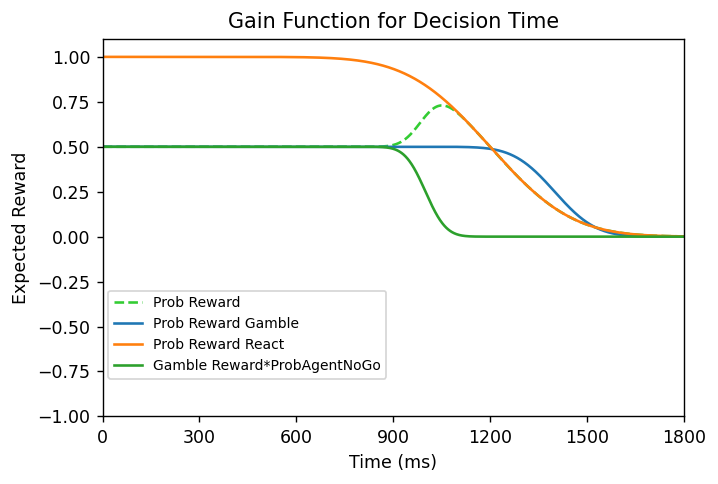

Optimal Decision Time: 1051
Gamble Target Reach Time: 1151
Reaction Target Reach Time: 1351


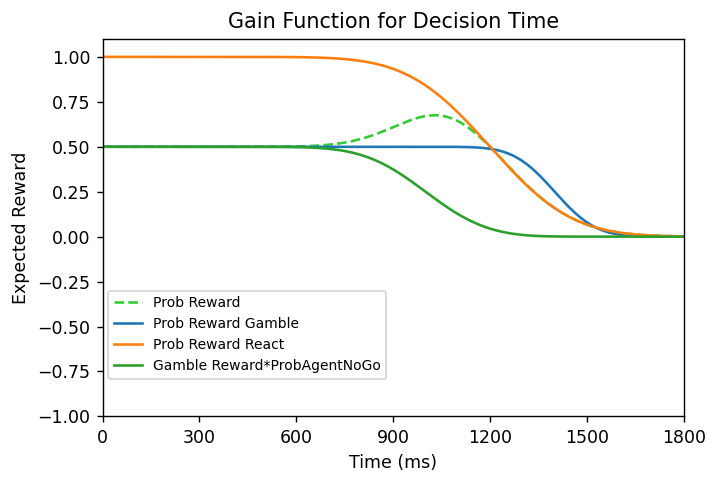

Optimal Decision Time: 1028
Gamble Target Reach Time: 1128
Reaction Target Reach Time: 1328


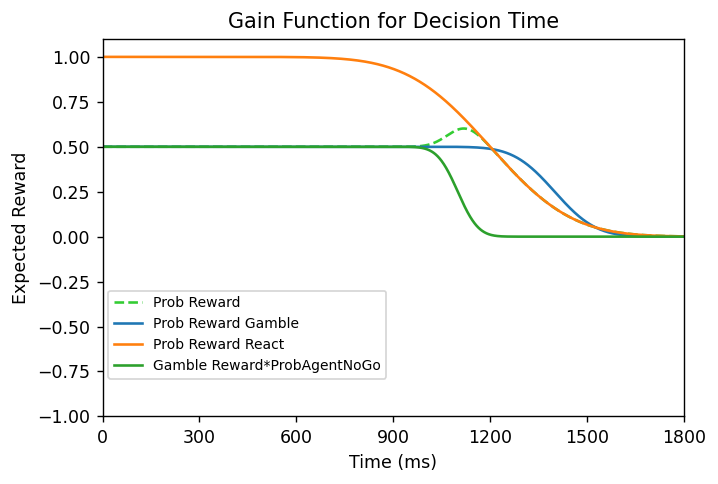

Optimal Decision Time: 1118
Gamble Target Reach Time: 1218
Reaction Target Reach Time: 1418


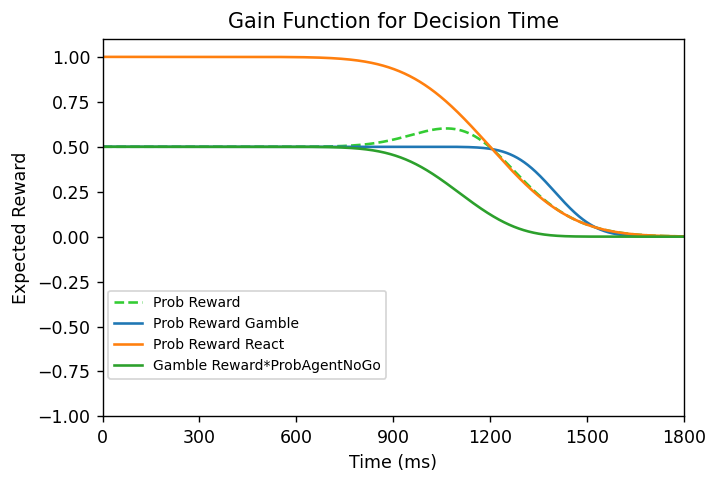

Optimal Decision Time: 1065
Gamble Target Reach Time: 1165
Reaction Target Reach Time: 1365


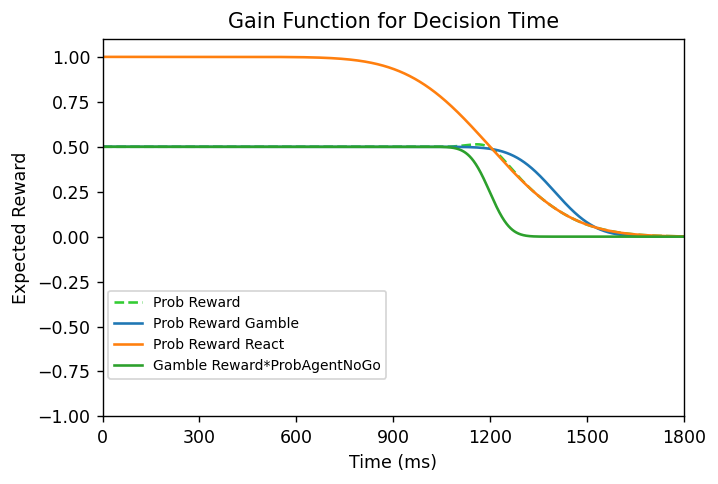

Optimal Decision Time: 1159
Gamble Target Reach Time: 1259
Reaction Target Reach Time: 1459


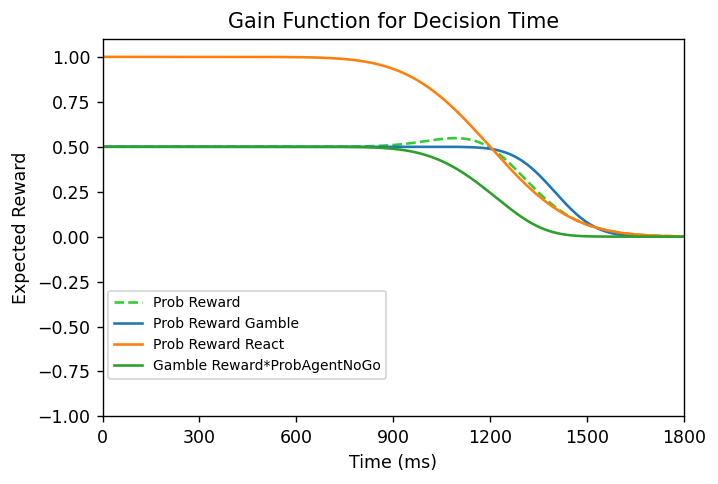

Optimal Decision Time: 1092
Gamble Target Reach Time: 1192
Reaction Target Reach Time: 1392
Reaction Time: 200
Movement Time: 100
Reaction Movement Uncertainty: 200
Movement Uncertainty: 100
[1051. 1028. 1118. 1065. 1159. 1092.]


In [53]:
optimal_decision_times = np.zeros(len(agent_means))
optimal_reach_times = np.zeros(len(agent_means))
i=-1
for mean,std in zip(agent_means,agent_stds):
    i+=1
    optimal_decision_times[i] = find_optimal_decision_time(mean, std, reaction_time, movement_time, reaction_movement_uncertainty, movement_uncertainty,plot=True)

print(f'Reaction Time: {reaction_time}')
print(f'Movement Time: {movement_time}')
print(f'Reaction Movement Uncertainty: {reaction_movement_uncertainty}')
print(f'Movement Uncertainty: {movement_uncertainty}')
print(optimal_decision_times)

## Find Wins, Indecisions, Incorrects

### Optimal Decision Time

1. Optimal Decision Time = $DT^* = argmax(ER)$

### Reach Times

1. Target Reach Time on Gamble = $TRT_{G} = DT^* + \mu_{MT}$

2. Target Reach Time on Reaction = $TRT_{R} = DT^* + \mu_{MT} + \mu_{RT}$

### Probability of Reacting and Gambling given Optimal Decision Time

1. $\mu_{diff} = DT^* - \mu_{ADT}$

2. $\sigma_{diff}^2 = \sigma_{P}^2 + \sigma_{ADT}^2$

3. Probability of Reacting = $P(R|DT^*) = P(\mu_{diff}>0|\sigma_{diff})$

4. Probability of Gambling = $P(G|DT*) = 1 - P(Reacting)$

Note: This feels BAYESIAN.. before I had the probability of wins, indecisions, incorrects given I react
- Now I have the probabilty of Reacting given the decision time

### Probability of Indecision Given Optimal Decision Time

1. Probability Indecision on Gamble = $P(I|G) = P(TRT_{G}>1500|\sigma_{MT})$

1. Probability Indecision on Reaction = $P(I|R) = P(TRT_{R}>1500|\sigma_{RMT})$

3. Probability of Indecision = $P(I|DT^*) = P(R|DT^*)*P(I|R) + P(G|DT^*)*P(I|G)$

### Probability of Win Given Optimal Decision Time

1. Probability Win on Gamble = $P(W|G) = P(TRT_{G}<1500|\sigma_{MT})*0.5$

1. Probability Win on Reaction = $P(W|R) = P(TRT_{R}<1500|\sigma_{RMT})*1.0$

3. Probability of Win = $P(W|DT^*) = P(R|DT^*)*P(W|R) + P(G|DT^*)*P(W|G)$

### Probability of Incorrect Given Optimal Decision Time

1. Probability Incorrect on Gamble = $P(L|G) = P(TRT_{G}<1500|\sigma_{MT})*0.5$

1. Probability Incorrect on Reaction = $P(L|R) = P(TRT_{R}<1500|\sigma_{RMT})*1.0$

3. Probability of Incorrect = $P(L|DT^*) = P(R|DT^*)*P(L|R) + P(G|DT^*)*P(L|G)$

In [54]:
# Establish reach times
reach_time_gamble = optimal_decision_times + movement_time
reach_time_reaction = optimal_decision_times + reaction_time + movement_time

# Calculate difference of distributions
mean_diff = optimal_decision_times - agent_means
std_diff = np.sqrt(reaction_movement_uncertainty**2 + agent_stds**2) 
prob_react = 1 - stats.norm.cdf(0, mean_diff,std_diff) # Probability that optimal decision time is after the agent goes (aka we react)  NEEDED TO DO THE TWO DISTRIBUTION DIFFERENCE THING
prob_gamble = 1 - prob_react

prob_indecision_if_react = 1 - stats.norm.cdf(1500,reach_time_reaction,reaction_movement_uncertainty) # Probability that the reach time reaction is > 1500 
prob_indecision_if_gamble = 1 - stats.norm.cdf(1500,reach_time_gamble,movement_uncertainty)
prob_indecision = prob_react*prob_indecision_if_react + prob_gamble*prob_indecision_if_gamble


prob_win_if_react = (1-prob_indecision_if_react)*1.0 # prob win if react is the probability that I don't make a decision times the probability that i select the right target (1.0)
prob_win_if_gamble = (1-prob_indecision_if_gamble)*0.5 # prob win if gamble is the probability that I don't make a decision times the probabiliyt that I select the right target(0.5)


prob_incorrect_if_react = np.array([0]*len(agent_means))
prob_incorrect_if_gamble = (1-prob_indecision_if_gamble)*0.5

prob_win = prob_react*prob_win_if_react + prob_gamble*prob_win_if_gamble

prob_incorrect = prob_react*prob_incorrect_if_react + prob_gamble*prob_incorrect_if_gamble
print(f'Agent means = {agent_means}')
print(f'Agent Stds = {agent_stds}')
print(f'Prob indecision = {prob_indecision*100}')
print(f'Prob win =        {prob_win*100}')
print(f'Prob incorrect =  {prob_incorrect*100}')
print(prob_indecision + prob_win + prob_incorrect)

Agent means = [1000 1000 1100 1100 1200 1200]
Agent Stds = [ 50 150  50 150  50 150]
Prob indecision = [13.64529094 10.61826396 18.34280714 11.12349879 18.10005639  9.87536971]
Prob win =        [66.24433592 66.61341909 58.45247424 61.10422711 53.18971587 56.80268966]
Prob incorrect =  [20.11037313 22.76831695 23.20471863 27.7722741  28.71022773 33.32194063]
[1. 1. 1. 1. 1. 1.]


## Plot Data and Optimals

Decision Times

In [55]:
# Calculate what the LEAVE TARGET TIME IS FOR THE OPTIMAL SIMULATION
# Because people's decision time on gambles is equal to the target leave time
# And people's decision time on reactions is equal to target leave time - reaction time
# SO in the optimal, I need to calculate the target leave time based on the probabiilty of gamble and react and what time they would leave if they did react or gamble
optimal_gamble_decision_times = optimal_decision_times
optimal_reaction_decision_times = optimal_decision_times + reaction_time
wtd_optimal_mean_left_target_time = (prob_gamble*optimal_gamble_decision_times + prob_react*optimal_reaction_decision_times)

In [56]:
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(400,1800,150)
plt.figure(dpi = 125, figsize = (10,5))
ax=plt.subplot()
reaction_time_matrix = np.vstack([player_reaction_time_mean] * player_mean_decision_time.shape[1]).T
true_decision_time = player_mean_decision_time #- reaction_time_matrix
boxplot(true_decision_time, box_widths=0.05, xlocs = xlocs, ylocs= ylocs, xlab = "Agent Mean (SD) Decision Time (ms)",
        ylab='Time (ms)', title='Decision Times')
dv.jitter_array(ax,xlocs,true_decision_time.T,0.1, circle_size = 60, circle_lw = 1,lw = 1, circle_alpha = 0.7, include_mean = True)
ax.plot(xlocs, wtd_optimal_mean_left_target_time, marker = 'o',markersize = 8.5, c= wheel.orange)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(850,1600)
dv.Custom_Legend(ax, ['Participant Mean Decision Time','Optimal Mean Decision Time'], [wheel.grey,wheel.orange], fontsize = 12)
#plt.savefig(PATH+SAVE_PATH+'decision_times_boxplots', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()

NameError: name 'num_blocks' is not defined

Indecisions

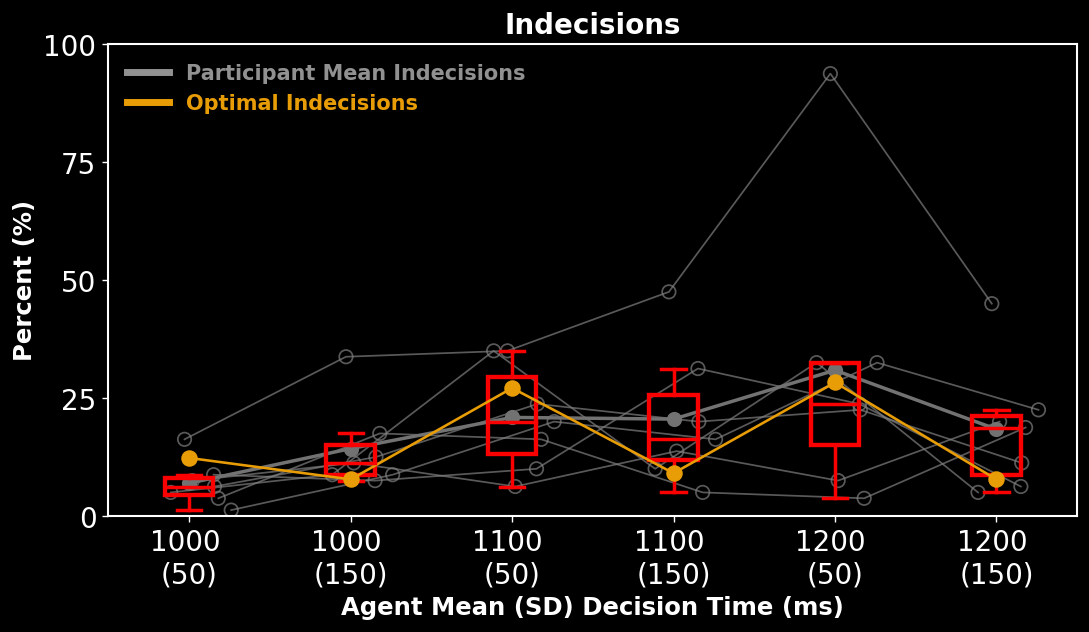

In [ ]:
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(0,125,25)
plt.figure(dpi = 125, figsize = (10,5))
ax=plt.subplot()
boxplot(perc_player_indecisions, box_widths=0.05, xlocs = xlocs, ylocs= ylocs, xlab = "Agent Mean (SD) Decision Time (ms)",
        ylab='Percent (%)', title='Indecisions')
dv.jitter_array(ax,xlocs,perc_player_indecisions.T,0.1, circle_size = 60, circle_lw = 1,lw = 1, circle_alpha = 0.7, include_mean = True)
ax.plot(xlocs, prob_indecision*100, marker = 'o',markersize = 8.5, c= wheel.orange)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
dv.Custom_Legend(ax, ['Participant Mean Indecisions','Optimal Indecisions'], [wheel.grey,wheel.orange], fontsize = 12)
#plt.savefig(PATH+SAVE_PATH+'decision_times_boxplots', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()

Wins

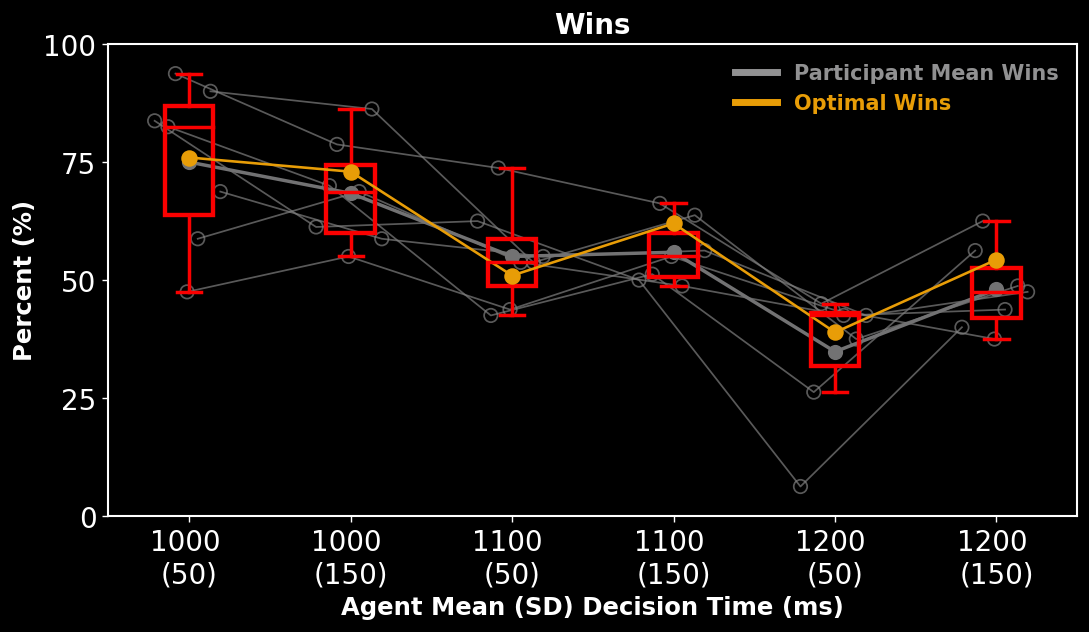

In [ ]:
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(0,125,25)
plt.figure(dpi = 125, figsize = (10,5))
ax=plt.subplot()
boxplot(perc_player_wins, box_widths=0.05, xlocs = xlocs, ylocs= ylocs, xlab = "Agent Mean (SD) Decision Time (ms)",
        ylab='Percent (%)', title='Wins')
dv.jitter_array(ax,xlocs,perc_player_wins.T,0.1, circle_size = 60, circle_lw = 1,lw = 1, circle_alpha = 0.7, include_mean = True )
ax.plot(xlocs, prob_win*100, marker = 'o',markersize = 8.5, c= wheel.orange)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
dv.Custom_Legend(ax, ['Participant Mean Wins','Optimal Wins'], [wheel.grey,wheel.orange], fontsize = 12)
#plt.savefig(PATH+SAVE_PATH+'decision_times_boxplots', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()

Incorrects

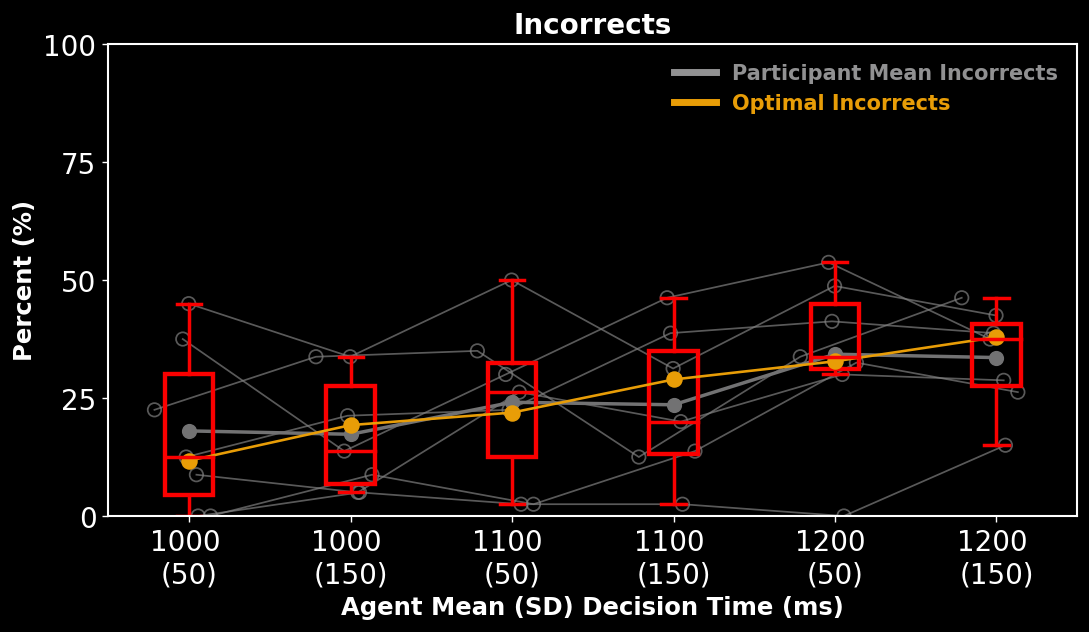

In [ ]:
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(0,125,25)
plt.figure(dpi = 125, figsize = (10,5))
ax=plt.subplot()
boxplot(perc_player_incorrects, box_widths=0.05, xlocs = xlocs, ylocs= ylocs, xlab = "Agent Mean (SD) Decision Time (ms)",
        ylab='Percent (%)', title='Incorrects')
dv.jitter_array(ax,xlocs,perc_player_incorrects.T,0.1, circle_size = 60, circle_lw = 1,lw = 1, circle_alpha = 0.7, include_mean = True )
ax.plot(xlocs, prob_incorrect*100, marker = 'o',markersize = 8.5, c= wheel.orange)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
dv.Custom_Legend(ax, ['Participant Mean Incorrects','Optimal Incorrects'], [wheel.grey,wheel.orange], fontsize = 12)
#plt.savefig(PATH+SAVE_PATH+'decision_times_boxplots', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()

Gambles and Reaction Wins

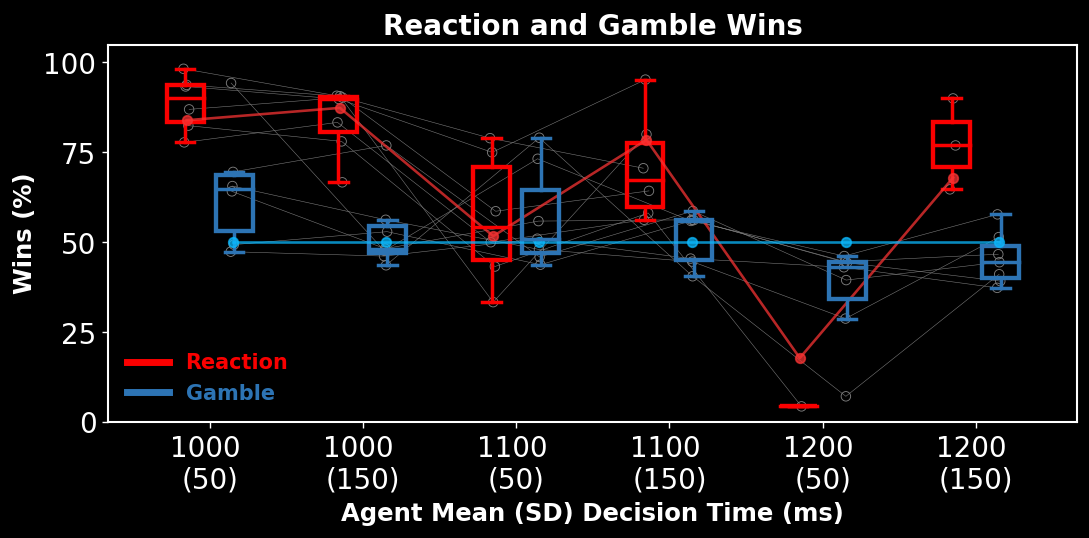

In [ ]:
# Out of x number of reaction trials, this percentage was how many they won (same for gambles)
# So it's  percent = reaction_wins/total_reaction_trials
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(0,125,25)
box_width = 0.04
plt.figure(dpi=125, figsize=(10,4))
ax=plt.subplot()
boxplot(perc_reaction_wins, xlocs=xlocs, ylocs=ylocs, box_widths = box_width, shift_box = True, shift_direction = -1, legend_labels = ['Reaction', "Gamble"], xlab = "Agent Mean Reach Time (ms)",
        ylab='Incorrect Decisions (%)', title='Incorrect Decisions')
dv.jitter_array(ax=ax,x_positions=xlocs-0.15,data_list=perc_reaction_wins.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs-0.15, prob_win_if_react*100, marker = 'o',markersize = 5.5, c= wheel.red, alpha = 0.75)

boxplot(perc_gamble_wins, xlocs, ylocs, box_widths = box_width, shift_box = True, shift_direction = 1, legend_labels = ['Reaction', "Gamble"],xlab = "Agent Mean (SD) Decision Time (ms)",
        ylab='Wins (%)', title='Reaction and Gamble Wins')
ax.plot(xlocs+0.15, prob_win_if_gamble*100, marker = 'o',markersize = 5.5, c= wheel.light_blue, alpha = 0.75)

dv.jitter_array(ax=ax,x_positions=xlocs+0.15,data_list=perc_gamble_wins.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.set_ylim(0,105)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
#plt.savefig(PATH+SAVE_PATH+'reaction_and_gamble_decision_times_boxplots_no_dots', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()

Reaction and Gamble Indecisions

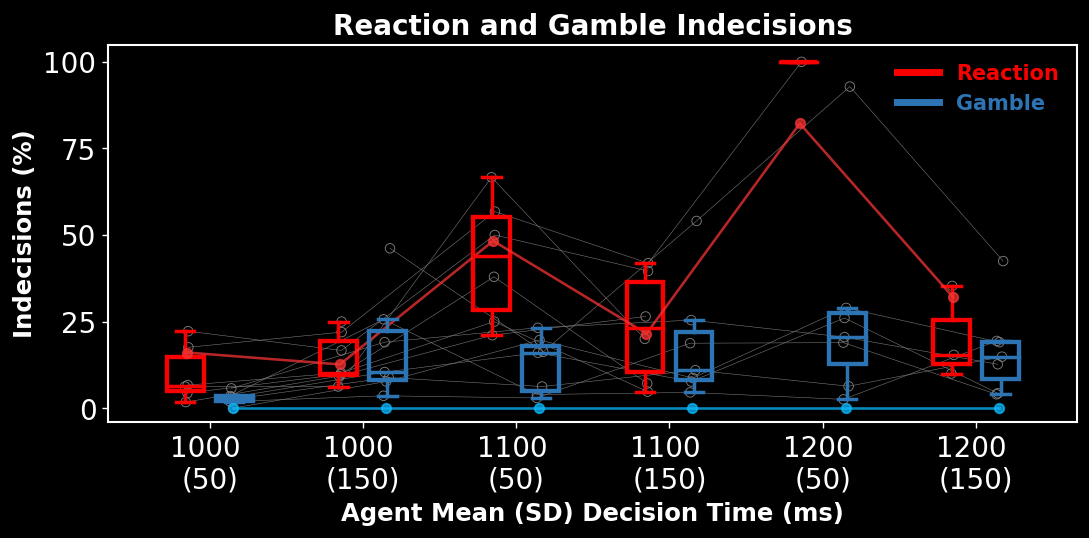

In [ ]:
# Percent = reaction indecisions / total Reaction trials
# !!!!!!!! WHEN THEY REACTED, HOW OFTEN DID THEY MAKE AN INDECISION
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(0,125,25)
box_width = 0.04
plt.figure(dpi=125, figsize=(10,4))
ax=plt.subplot()
boxplot(perc_reaction_indecisions, xlocs=xlocs, ylocs=ylocs, box_widths = box_width, shift_box = True, shift_direction = -1, legend_labels = ['Reaction', "Gamble"], xlab = "Agent Mean Reach Time (ms)",
        ylab='Incorrect Decisions (%)', title='Incorrect Decisions')
dv.jitter_array(ax=ax,x_positions=xlocs-0.15,data_list=perc_reaction_indecisions.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs-0.15, prob_indecision_if_react*100, marker = 'o',markersize = 5.5, c= wheel.red, alpha = 0.75)

boxplot(perc_gamble_indecisions, xlocs, ylocs, box_widths = box_width, shift_box = True, shift_direction = 1, legend_labels = ['Reaction', "Gamble"],xlab = "Agent Mean (SD) Decision Time (ms)",
        ylab='Indecisions (%)', title='Reaction and Gamble Indecisions')
dv.jitter_array(ax=ax,x_positions=xlocs+0.15,data_list=perc_gamble_indecisions.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs+0.15, prob_indecision_if_gamble*100, marker = 'o',markersize = 5.5, c= wheel.light_blue, alpha = 0.75)

ax.set_ylim(-4,105)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
#plt.savefig(PATH+SAVE_PATH+'reaction_and_gamble_decision_times_boxplots_no_dots', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()

Reaction Gamble Incorrects

In [ ]:
prob_incorrect_if_react

array([0, 0, 0, 0, 0, 0])

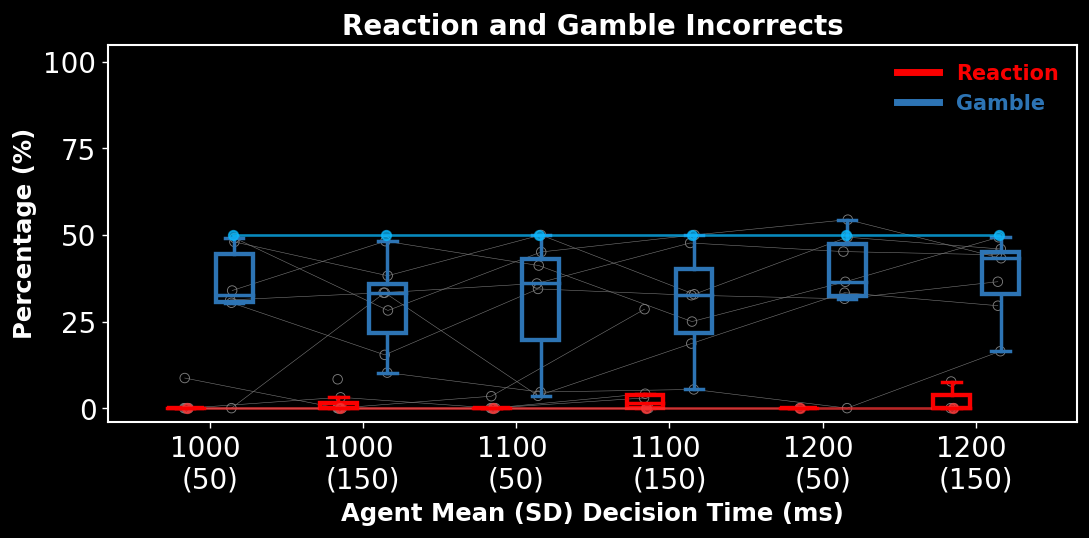

In [ ]:
# Percent = reaction incorrects / total Reaction trials
# !!!!!!!! WHEN THEY REACTED, HOW OFTEN DID THEY MAKE AN incorrects
xlocs = np.arange(0, num_blocks)
ylocs = np.arange(0,125,25)
box_width = 0.04
plt.figure(dpi=125, figsize=(10,4))
ax=plt.subplot()
boxplot(perc_reaction_incorrects, xlocs=xlocs, ylocs=ylocs, box_widths = box_width, shift_box = True, shift_direction = -1, legend_labels = ['Reaction', "Gamble"], xlab = "Agent Mean Reach Time (ms)",
        ylab='Incorrect Decisions (%)', title='Incorrect Decisions')
dv.jitter_array(ax=ax,x_positions=xlocs-0.15,data_list=perc_reaction_incorrects.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs-0.15, prob_incorrect_if_react*100, marker = 'o',markersize = 5.5, c= wheel.red, alpha = 0.75)

boxplot(perc_gamble_incorrects, xlocs, ylocs, box_widths = box_width, shift_box = True, shift_direction = 1, legend_labels = ['Reaction', "Gamble"],xlab = "Agent Mean (SD) Decision Time (ms)",
        ylab='Percentage (%)', title='Reaction and Gamble Incorrects')
dv.jitter_array(ax=ax,x_positions=xlocs+0.15,data_list=perc_gamble_incorrects.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs+0.15, prob_incorrect_if_gamble*100, marker = 'o',markersize = 5.5, c= wheel.light_blue, alpha = 0.75)

ax.set_ylim(-4,105)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
#plt.savefig(PATH+SAVE_PATH+'reaction_and_gamble_decision_times_boxplots_no_dots', dpi = 400, transparent = True, bbox_inches='tight')
plt.show()